In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import *

from sklearn.metrics import r2_score 

# Волкова Татьяна ПИ19-2 Билет 23



## Задание 1

НА ЛИСТОЧКЕ

## Задание 2
При помощи возможностей по автоматическому дифференцированию, которые предоставляет библиотека PyTorch, найдите минимум функции  y=(x**2−25x+10)/x  на отрезке [0.5, 24]. Реализуйте процесс поиска экстремума таким образом, чтобы при нахождении точки экстремума процедура поиска останавливалась. Продемонстрируйте процесс оптимизации. Изобразите график функции y(x) на заданном отрезке.

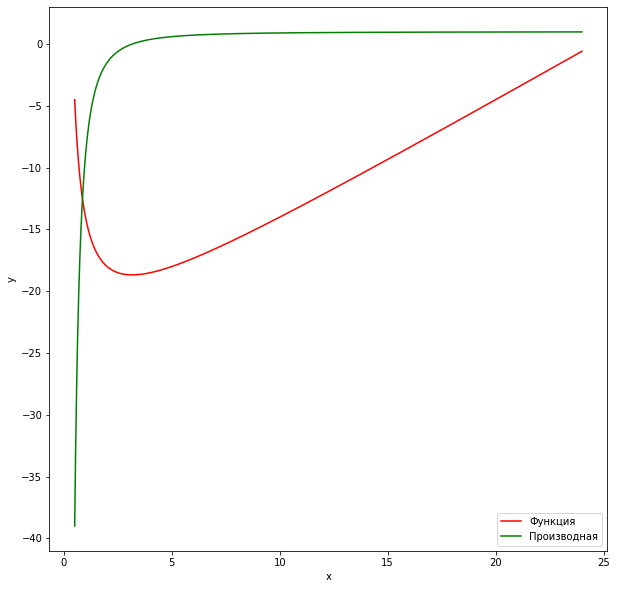

In [52]:
x = torch.arange(0.5, 24, 0.001, requires_grad = True)
Y = ((x)**2 - 25*x + 10) / x
y = torch.sum(Y)
y.backward()
 
# отрисовка функции и производной
plt.plot(x.detach().numpy(), Y.detach().numpy(), label = 'Функция', color='red')
plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label = 'Производная', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [65]:
class Func():
  def __init__(self, x):
    self.x = torch.autograd.Variable(x, requires_grad=True)

  def forward(self):
    return ((self.x)**2 - 25*self.x + 10) / self.x
  
  def backward(self):
    return (((self.x)**2 - 25*self.x + 10) / self.x).backward()

x_r = torch.arange(0.5, 24, 0.001, dtype=float)
optimizer = torch.optim.Adam([x_r], lr=0.0001)
mini = 0

for epoch in range(100):
  for x_ in x_r:
    x = torch.Tensor([x_]).requires_grad_()
    func = Func(x)
    optimizer.zero_grad()
    y = func.forward()
    y.backward()
    if (y.item()<mini):
        mini = y.item()
    elif (y.item()>mini):
        break
  optimizer.step()

print(f'Минимальное значение ->> {mini}')

Минимальное значение ->> -18.675445556640625


## Задание 3
Реализовав (рекуррентную) нейронную сеть при помощи библиотеки PyTorch, решите задачу классификации (текстов). Разделите набор данных на обучающее и тестовое множество. Проверьте, является ли выборка сбалансированной. При проведении процедуры обучения на несбалансированной выборке задайте параметр weight при создании функции потерь. Отобразите графики значений функции потерь на обучающем множестве. Отобразите confusion matrix и classification report, рассчитанные на основе тестового множества.

Датасет: classification/income.csv
Целевой столбец - income>50

### Предобработка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/exam/classification/income.csv")
print(df.shape)
df.head()

(32561, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [6]:
df.isnull().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income >50K          0
dtype: int64

In [7]:
# вроде относительно общего объема данных, пропусков не так много, чтоб не заполнять удалю
df = df.dropna()
df.isnull().sum().sum() 

0

In [9]:
df.nunique()

age                72
workclass           7
education          16
education-num      16
marital-status      7
occupation         14
relationship        6
race                5
sex                 2
capital-gain      118
capital-loss       90
hours-per-week     94
native-country     41
income >50K         2
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   education       30162 non-null  object
 3   education-num   30162 non-null  int64 
 4   marital-status  30162 non-null  object
 5   occupation      30162 non-null  object
 6   relationship    30162 non-null  object
 7   race            30162 non-null  object
 8   sex             30162 non-null  object
 9   capital-gain    30162 non-null  int64 
 10  capital-loss    30162 non-null  int64 
 11  hours-per-week  30162 non-null  int64 
 12  native-country  30162 non-null  object
 13  income >50K     30162 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [12]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# численные столбцы нормализуем
scaler = MinMaxScaler()
df[['age','education-num','capital-gain','capital-loss','hours-per-week']] = scaler.fit_transform(df[['age','education-num','capital-gain','capital-loss','hours-per-week']])

# преобразуем все нечисленные столбцы в численный формат
labeler = LabelEncoder()
for column in df.columns:
    if df[column].dtype==np.number:
        continue
    else: df[column]=labeler.fit_transform(df[column])

<ipython-input-12-34d2c01b4286>:10: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[column].dtype==np.number:


In [13]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30162 non-null  float64
 1   workclass       30162 non-null  int64  
 2   education       30162 non-null  int64  
 3   education-num   30162 non-null  float64
 4   marital-status  30162 non-null  int64  
 5   occupation      30162 non-null  int64  
 6   relationship    30162 non-null  int64  
 7   race            30162 non-null  int64  
 8   sex             30162 non-null  int64  
 9   capital-gain    30162 non-null  float64
 10  capital-loss    30162 non-null  float64
 11  hours-per-week  30162 non-null  float64
 12  native-country  30162 non-null  int64  
 13  income >50K     30162 non-null  int64  
dtypes: float64(5), int64(9)
memory usage: 3.5 MB
None


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,0.309859,5,9,0.800000,4,0,1,4,1,0.205128,0.0,0.419355,38,0
1,0.464789,4,9,0.800000,2,3,0,4,1,0.000000,0.0,0.129032,38,0
2,0.295775,2,11,0.533333,0,5,1,4,1,0.000000,0.0,0.419355,38,0
3,0.507042,2,1,0.400000,2,5,0,2,1,0.000000,0.0,0.419355,38,0
4,0.154930,2,9,0.800000,2,9,5,2,0,0.000000,0.0,0.419355,4,0


0    22654
1     7508
Name: income >50K, dtype: int64


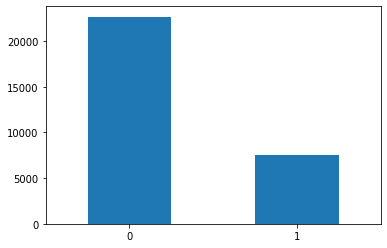

In [15]:
# распределение классов 
vc = df["income >50K"].value_counts()
print(vc)
df["income >50K"].value_counts().plot.bar(rot=0)

## очень несбалансированно

In [27]:
class_weights = torch.tensor(df['income >50K'].value_counts().sum() - df['income >50K'].value_counts()) / df['income >50K'].value_counts().sum()

### Построение и обучение модели

In [17]:
class IncomeDataset(Dataset):

    def __init__(self):
        self.X = torch.from_numpy(df[df.columns.drop("income >50K")].to_numpy()).to(torch.float)
        self.y = torch.from_numpy(df["income >50K"].to_numpy()).to(torch.long)
        self.n_classes = len(self.y.unique())

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
# архитектура модели (рекурентные я не знаю)
class Classificator(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, out_features),
        )

    def forward(self, x):
        return self.classifier(x)

In [33]:
# шаг пакетного обучения
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    losses = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        losses += loss
        avg_loss = losses / num_batches
    return avg_loss 

In [84]:
epochs = 50
learning_rate = 1e-3
batch_size = 128

dataset = IncomeDataset()
train_size = round(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, (train_size, len(dataset) - train_size))
print(len(train_dataset), len(test_dataset))

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
model = Classificator(in_features=dataset.X.size(1), out_features=len(dataset.y.unique()))
optimizer= torch.optim.SGD(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

24130 6032


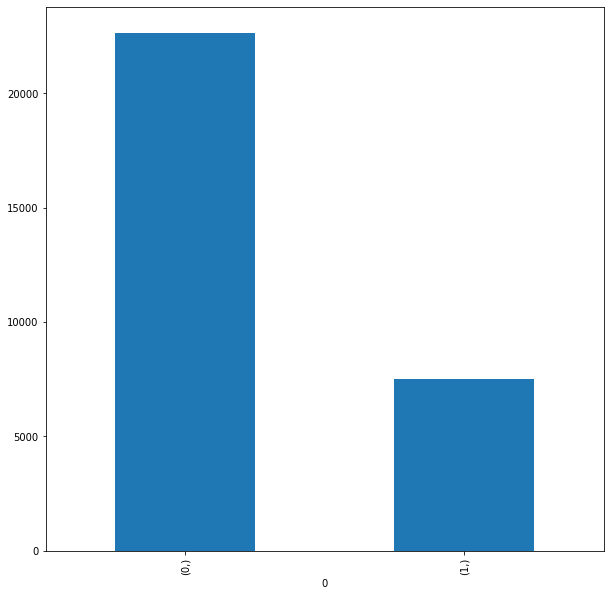

In [85]:
pd.DataFrame(train_dataset.dataset.y.detach().numpy()).value_counts().plot.bar() 

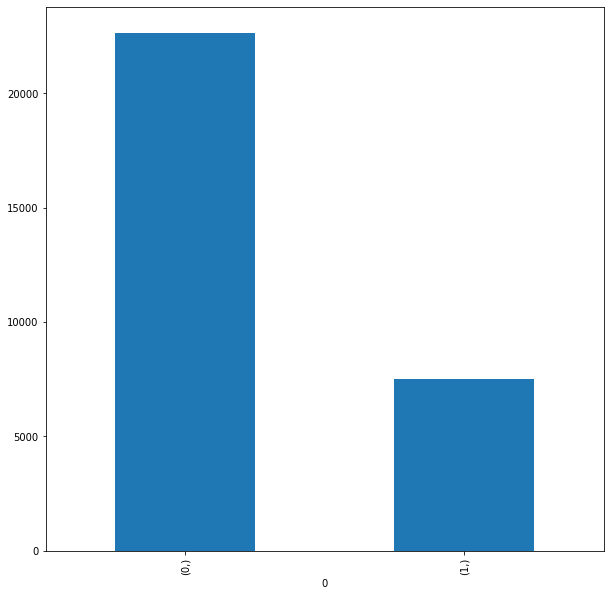

In [86]:
pd.DataFrame(test_dataset.dataset.y.detach().numpy()).value_counts().plot.bar() 

In [87]:
losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(train_loss)

Epoch 1
-------------------------------
loss: 1.399992  [    0/24130]
loss: 1.010016  [ 6400/24130]
loss: 0.913517  [12800/24130]
loss: 0.791148  [19200/24130]
Epoch 2
-------------------------------
loss: 0.873110  [    0/24130]
loss: 0.831519  [ 6400/24130]
loss: 0.828085  [12800/24130]
loss: 0.714887  [19200/24130]
Epoch 3
-------------------------------
loss: 0.702727  [    0/24130]
loss: 0.698785  [ 6400/24130]
loss: 0.737367  [12800/24130]
loss: 0.652934  [19200/24130]
Epoch 4
-------------------------------
loss: 0.696420  [    0/24130]
loss: 0.677065  [ 6400/24130]
loss: 0.675275  [12800/24130]
loss: 0.676659  [19200/24130]
Epoch 5
-------------------------------
loss: 0.702989  [    0/24130]
loss: 0.711256  [ 6400/24130]
loss: 0.705759  [12800/24130]
loss: 0.693310  [19200/24130]
Epoch 6
-------------------------------
loss: 0.719506  [    0/24130]
loss: 0.692457  [ 6400/24130]
loss: 0.701591  [12800/24130]
loss: 0.696954  [19200/24130]
Epoch 7
-------------------------------


### Оценка результатов

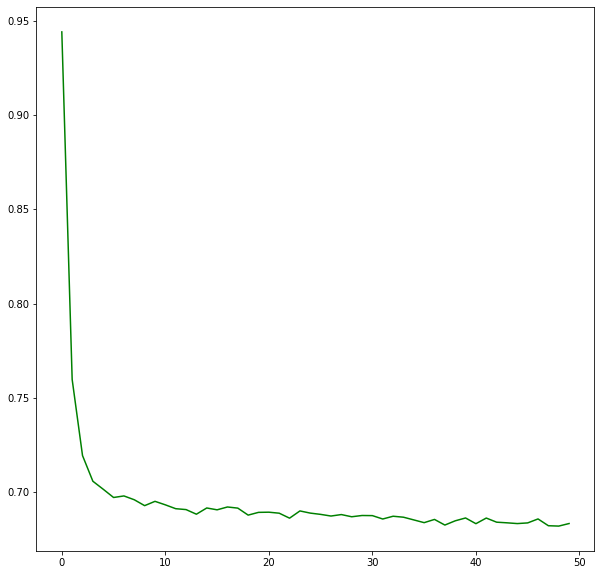

In [88]:
with torch.no_grad():
  plt.plot(losses, color='green')

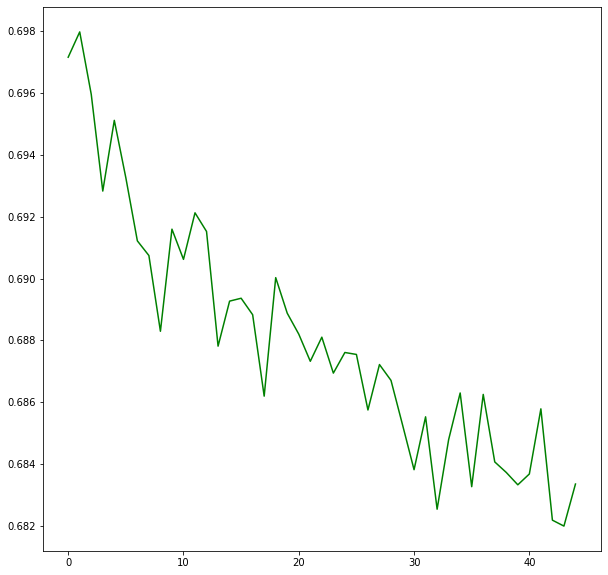

In [89]:
with torch.no_grad():
    plt.plot(losses[5:], color='green')

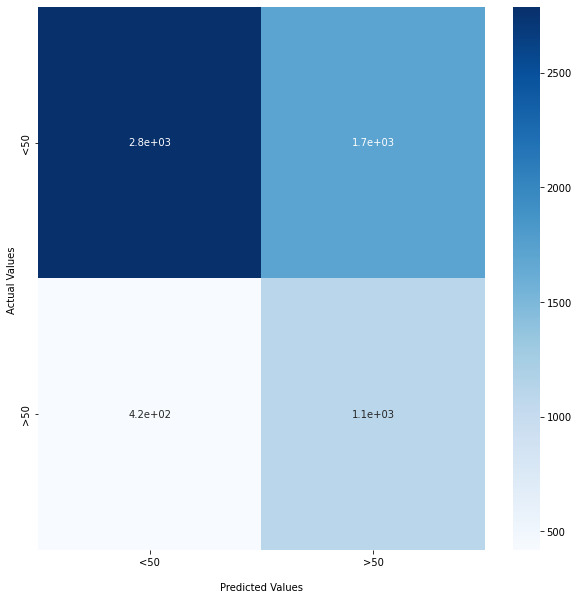

In [90]:
from sklearn.metrics import confusion_matrix

model.eval() # отключаем droput
X_test, y_true = next(iter(test_dataloader))
y_pred = model(X_test).argmax(dim=1)

cm = confusion_matrix(y_true, y_pred)

import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 10)

ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['<50', '>50'])
ax.yaxis.set_ticklabels(['<50', '>50'])

plt.show()

In [91]:
from sklearn import metrics 

print(metrics.classification_report(y_true, y_pred, target_names=['no', 'yes'], zero_division=True))

              precision    recall  f1-score   support

          no       0.87      0.62      0.72      4512
         yes       0.39      0.73      0.51      1520

    accuracy                           0.65      6032
   macro avg       0.63      0.67      0.62      6032
weighted avg       0.75      0.65      0.67      6032



Accuracy 65% не очень конечно, но поэксперементировать с параметрами не очень успеваю и очень несбалансированный датасет